Demo using real data

In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import fitsio
import sys, os
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import wcs

In [2]:
def create_wcs(coadd_id):
    '''
    Create Astropy WCS object.
    '''
    # Create a new WCS object
    w = wcs.WCS(naxis=2)
    # Set up gnomonic projection
    w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    # WCS parameters
    w.wcs.cd = coadd['CD'][coadd_id]
    w.wcs.crval = coadd['CRVAL'][coadd_id]
    w.wcs.crpix = coadd['CRPIX'][coadd_id]
    # CDELT is ignored since cd is present
    # # w.wcs.cdelt = coadd['CDELT'][coadd_id]
    w.wcs.lonpole = coadd['LONGPOLE'][coadd_id]
    w.wcs.latpole = coadd['LATPOLE'][coadd_id]
    # Epoch must be defined
    w.wcs.equinox = 2000.
    
    return w

In [3]:
coadd = fitsio.read('/Users/roz18/git/wise-mask-query/misc/astrom-atlas_radec_added.fits')
cat = fitsio.read('/Users/roz18/Documents/Data/desi_photoz/random_forest/lrg_20171106_rf_photoz_v0.1.fits', 
    columns=['ra', 'dec'])

In [4]:
ra1=np.array(coadd['ra_center'])
dec1=np.array(coadd['dec_center'])
ra2=np.array(cat['ra'])
dec2=np.array(cat['dec'])
skycat1=SkyCoord(ra1*u.degree,dec1*u.degree, frame='icrs')
skycat2=SkyCoord(ra2*u.degree,dec2*u.degree, frame='icrs')

# Find the nearest 3 coadds for each object
coadd_idx = np.zeros([3, len(cat)], dtype=int)
coadd_idx[0], d2d_1, _ = skycat2.match_to_catalog_sky(skycat1, nthneighbor=1)
coadd_idx[1], d2d_2, _ = skycat2.match_to_catalog_sky(skycat1, nthneighbor=2)
coadd_idx[2], d2d_3, _ = skycat2.match_to_catalog_sky(skycat1, nthneighbor=3)

In [5]:
# plt.hist(np.array(d2d_1/u.arcsec), 100, alpha=0.5)
# plt.hist(np.array(d2d_2/u.arcsec), 100, alpha=0.5)
# plt.hist(np.array(d2d_3/u.arcsec), 100, alpha=0.5)
# plt.show()

In [6]:
# Check if objects are the 3 nearest coadds
# and compute the distances to the nearest boundary
inside = np.zeros([3, len(cat)], dtype=bool)
order_str = ['nearest', 'second nearest', 'third nearest']
d2b = -1.*np.ones([3, len(cat)])

for index1 in range(3):
    idx_unique = np.unique(coadd_idx[index1])
    # Loop over unique coadds
    for index2 in range(len(idx_unique)):
        if index2%(len(idx_unique)//10)==0:
            print('{:.0f}%'.format(index2/len(idx_unique)*100))
        # Create Astropy WCS object
        coadd_id = idx_unique[index2]
        w = create_wcs(coadd_id)
        # select objects that are matched to that coadd
        cat_mask = coadd_idx[index1]==coadd_id
        # Convert RA/Dec to pixel coordinates
        world = np.array([ra2[cat_mask], dec2[cat_mask]]).transpose()
        pixcrd = w.wcs_world2pix(world, True)
        # [0.5, 0.5] and [2048.5, 2048.5] are the corners of the image
        mask = (pixcrd[:, 0]>0.5) & (pixcrd[:, 0]<2048.5)
        mask &= (pixcrd[:, 1]>0.5) & (pixcrd[:, 1]<2048.5)
        inside[index1, cat_mask] = mask
        pixcrd_x, pixcrd_y = pixcrd.transpose()
        d2b_all_boundaries = np.stack((pixcrd_x - 0.5, 2048.5-pixcrd_x, pixcrd_y - 0.5, 2048.5-pixcrd_y))
        d2b[index1][cat_mask] = np.min(d2b_all_boundaries, axis=0)
        
    print('{} ({:.1f}%) objects inside the {} coadd'
          .format(np.sum(inside[index1]), np.sum(inside[index1])/len(cat)*100., order_str[index1]))

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
2341251 (98.2%) objects inside the nearest coadd
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
196653 (8.2%) objects inside the second nearest coadd
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
12943 (0.5%) objects inside the third nearest coadd


In [7]:
if np.sum((~inside[0]) & (~inside[1]) & (~inside[2]))!=0:
    raise ValueError('EROR: coadd not found!')

inside_only_1 = inside[0] & (~inside[1]) & (~inside[2])
print('{} ({:.1f}%) objects only inside the nearest coadd'
      .format(np.sum(inside_only_1), np.sum(inside_only_1)/len(cat)*100.))
inside_only_2 = (~inside[0]) & inside[1] & (~inside[2])
print('{} ({:.1f}%) objects only inside the second nearest coadd'
      .format(np.sum(inside_only_2), np.sum(inside_only_2)/len(cat)*100.))
inside_only_3 = (~inside[0]) & (~inside[1]) & (inside[2])
print('{} ({:.1f}%) objects only inside the third nearest coadd'
      .format(np.sum(inside_only_3), np.sum(inside_only_3)/len(cat)*100.))
inside_two = inside[0] & inside[1]
print('{} ({:.1f}%) objects inside the nearest two coadds'
      .format(np.sum(inside_two), np.sum(inside_two)/len(cat)*100.))
inside_three = inside[0] & inside[1] & inside[2]
print('{} ({:.1f}%) objects inside all three coadds'
      .format(np.sum(inside_three), np.sum(inside_three)/len(cat)*100.))

2187676 (91.7%) objects only inside the nearest coadd
36808 (1.5%) objects only inside the second nearest coadd
0 (0.0%) objects only inside the third nearest coadd
152564 (6.4%) objects inside the nearest two coadds
4651 (0.2%) objects inside all three coadds


In [8]:
# Assign each object to a coadd index
coadd_idx_final = -1*np.ones(len(cat), dtype=int)
choice_id = np.zeros(len(cat), dtype=int)

# Objects that are not ambiguous
coadd_idx_final[inside_only_1] = coadd_idx[0][inside_only_1]
choice_id[inside_only_1] = 0
coadd_idx_final[inside_only_2] = coadd_idx[1][inside_only_2]
choice_id[inside_only_2] = 1
coadd_idx_final[inside_only_3] = coadd_idx[2][inside_only_3]
choice_id[inside_only_3] = 2

mask_overlap = (coadd_idx_final==-1)

# Assign negative distance to irrelavant coadds
# so that they will not be chosen
for index in range(3):
    d2b[index][~inside[index]] = -1.
    
# For objects inside 2 or 3 coadds, choose the coadd whose 
# boundaries are farthest away from the object
argmax = np.argmax(d2b, axis=0)
mask = mask_overlap & (argmax==0)
coadd_idx_final[mask] = coadd_idx[0][mask]
choice_id[mask] = 0
mask = mask_overlap & (argmax==1)
coadd_idx_final[mask] = coadd_idx[1][mask]
choice_id[mask] = 1
mask = mask_overlap & (argmax==2)
coadd_idx_final[mask] = coadd_idx[2][mask]
choice_id[mask] = 2

In [9]:
print('{} ({:.1f}%) objects belong to the nearest coadd'
      .format(np.sum(choice_id==0), np.sum(choice_id==0)/len(cat)*100.))
print('{} ({:.1f}%) objects belong to the second nearest coadd'
      .format(np.sum(choice_id==1), np.sum(choice_id==1)/len(cat)*100.))
print('{} ({:.1f}%) objects belong to the third nearest coadd'
      .format(np.sum(choice_id==2), np.sum(choice_id==2)/len(cat)*100.))

2319527 (97.2%) objects belong to the nearest coadd
65811 (2.8%) objects belong to the second nearest coadd
2 (0.0%) objects belong to the third nearest coadd


--------
## Some analysis

__All objects__

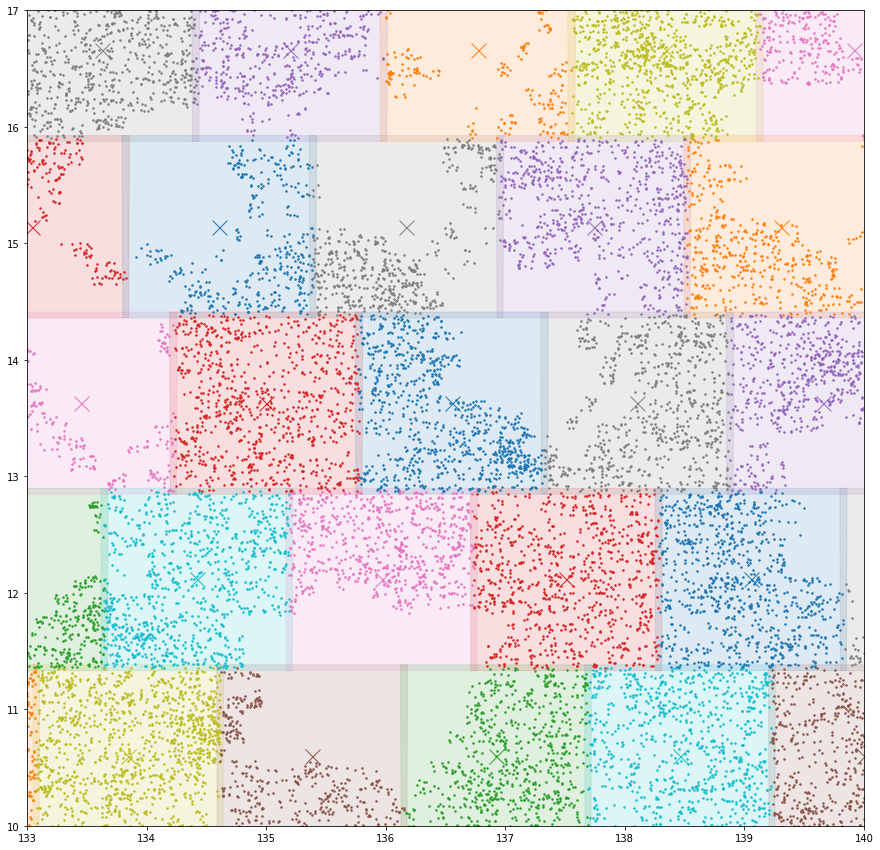

In [10]:
ramin, ramax = [133., 140.]
decmin, decmax = [10., 17.]

color_index = 0
patches = []
colors =[]
fig, ax = plt.subplots(figsize=(15, 15))
for index in range(len(coadd)):
    if (ramin-3<ra1[index]<ramax+3) and (decmin-2<dec1[index]<decmax+2):
        polygon = Polygon(
            np.stack((coadd['ra_corners'][index], 
                      coadd['dec_corners'][index])).transpose(),
                      True)
        patches.append(polygon)
        colors.append('C{}'.format(color_index%10))
        plt.plot(ra1[index], dec1[index], 'C{}x'.format(color_index%10), markersize=15)
        mask = (coadd_idx_final==index)
        plt.plot(ra2[mask], dec2[mask], 'C{}.'.format(color_index%10), markersize=3)
        color_index += 1
p = PatchCollection(patches, alpha=0.15)
p.set_color(colors)
ax.add_collection(p)
plt.axis([ramin, ramax, decmin, decmax])
plt.show()

__Objects in overlapping regions__

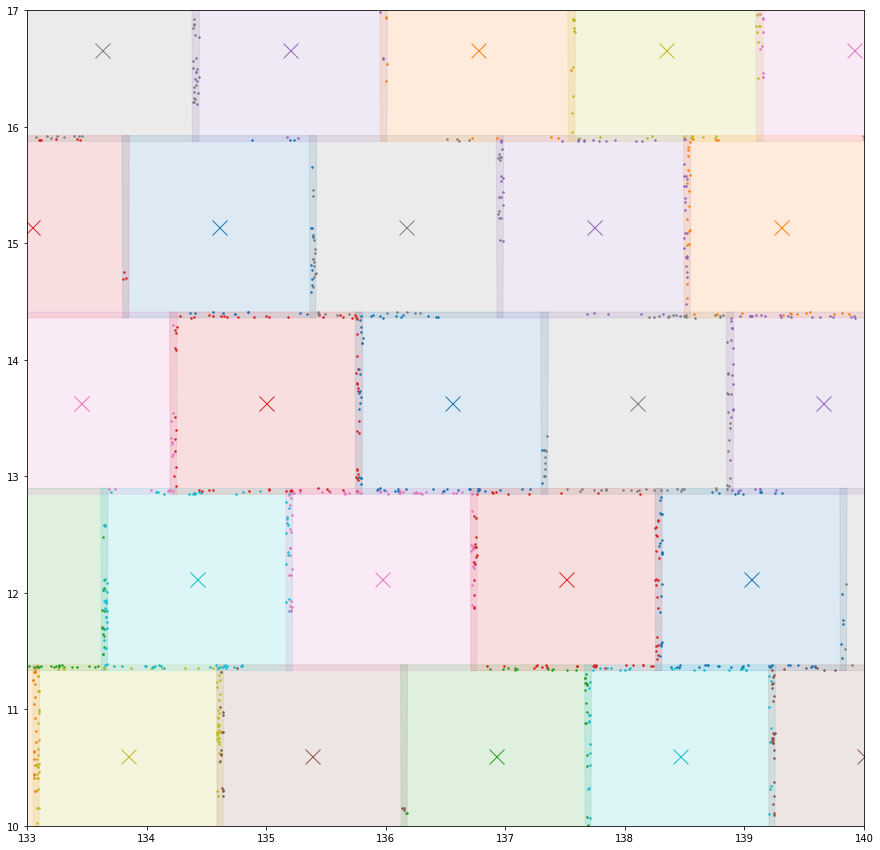

In [11]:
ramin, ramax = [133., 140.]
decmin, decmax = [10., 17.]

color_index = 0
patches = []
colors =[]
fig, ax = plt.subplots(figsize=(15, 15))
for index in range(len(coadd)):
    if (ramin-3<ra1[index]<ramax+3) and (decmin-2<dec1[index]<decmax+2):
        polygon = Polygon(
            np.stack((coadd['ra_corners'][index], 
                      coadd['dec_corners'][index])).transpose(),
                      True)
        patches.append(polygon)
        colors.append('C{}'.format(color_index%10))
        plt.plot(ra1[index], dec1[index], 'C{}x'.format(color_index%10), markersize=15)
        mask = mask_overlap & (coadd_idx_final==index)
        plt.plot(ra2[mask], dec2[mask], 'C{}.'.format(color_index%10), markersize=3)
        color_index += 1
p = PatchCollection(patches, alpha=0.15)
p.set_color(colors)
ax.add_collection(p)
plt.axis([ramin, ramax, decmin, decmax])
plt.show()

__Objects in that belong to the second nearest coadd__

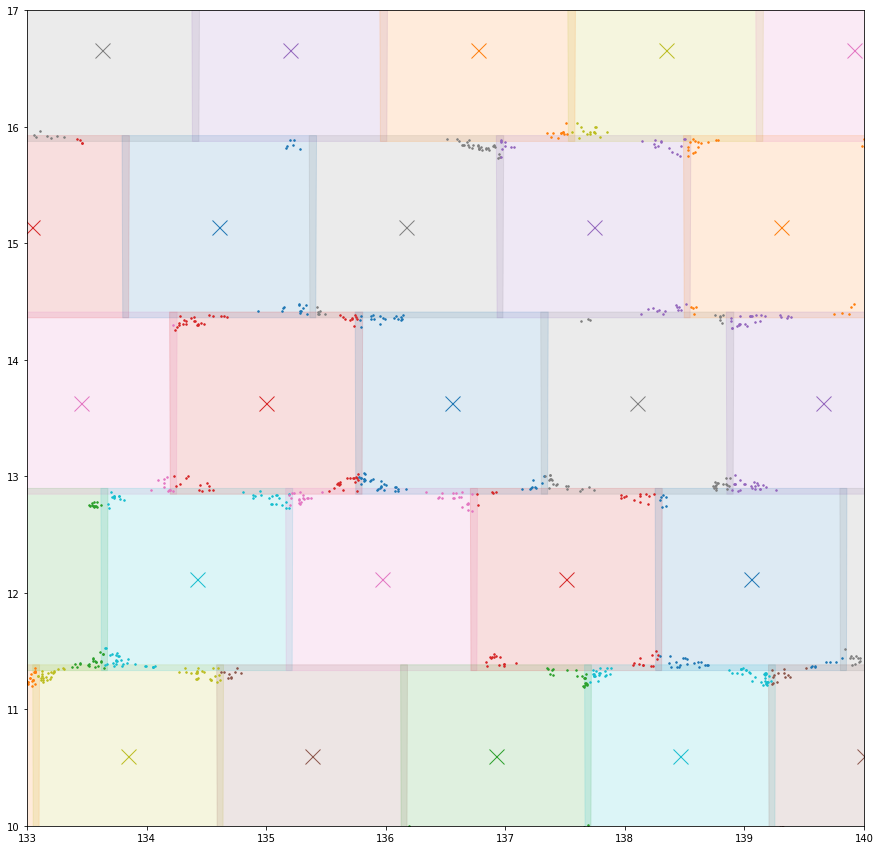

In [12]:
ramin, ramax = [133., 140.]
decmin, decmax = [10., 17.]

color_index = 0
patches = []
colors =[]
fig, ax = plt.subplots(figsize=(15, 15))
for index in range(len(coadd)):
    if (ramin-3<ra1[index]<ramax+3) and (decmin-2<dec1[index]<decmax+2):
        polygon = Polygon(
            np.stack((coadd['ra_corners'][index], 
                      coadd['dec_corners'][index])).transpose(),
                      True)
        patches.append(polygon)
        colors.append('C{}'.format(color_index%10))
        plt.plot(ra1[index], dec1[index], 'C{}x'.format(color_index%10), markersize=15)
        mask = (choice_id==1) & (coadd_idx_final==index)
        plt.plot(ra2[mask], dec2[mask], 'C{}.'.format(color_index%10), markersize=3)
        color_index += 1
p = PatchCollection(patches, alpha=0.15)
p.set_color(colors)
ax.add_collection(p)
plt.axis([ramin, ramax, decmin, decmax])
plt.show()

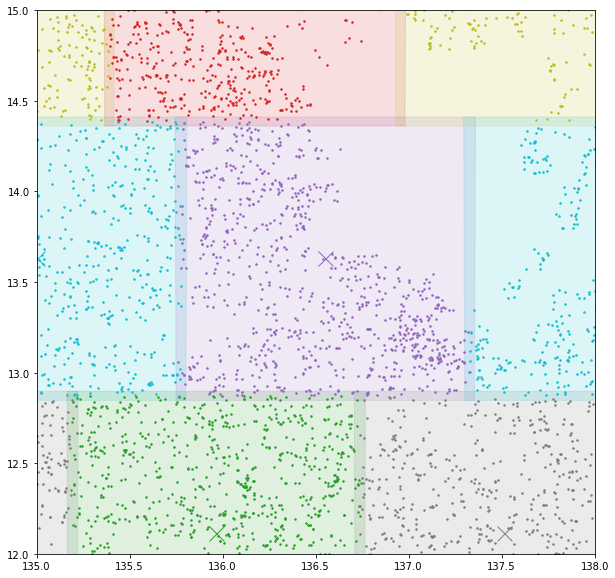

In [13]:
ramin, ramax = [135., 138.]
decmin, decmax = [12., 15.]

color_index = 0
patches = []
colors =[]
fig, ax = plt.subplots(figsize=(10, 10))
for index in range(len(coadd)):
    if (ramin-3<ra1[index]<ramax+3) and (decmin-2<dec1[index]<decmax+2):
        polygon = Polygon(
            np.stack((coadd['ra_corners'][index], 
                      coadd['dec_corners'][index])).transpose(),
                      True)
        patches.append(polygon)
        colors.append('C{}'.format(color_index%10))
        plt.plot(ra1[index], dec1[index], 'C{}x'.format(color_index%10), markersize=15)
        mask = (coadd_idx_final==index)
        plt.plot(ra2[mask], dec2[mask], 'C{}.'.format(color_index%10), markersize=3)
        color_index += 1
p = PatchCollection(patches, alpha=0.15)
p.set_color(colors)
ax.add_collection(p)
plt.axis([ramin, ramax, decmin, decmax])
plt.show()